## Hate Speech Detection in Social Media

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns
import latex
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\omkar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Reading Data:

In [2]:
# Davidson Dataset : https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv
df = pd.read_csv('labeled_data.csv')

### Attribute Information:

count = no. of CrowdFlower users who coded each tweet (min - 3, max upto 9).

hate_speech = no. of CF users that classified tweet to be hate speech.

offensive_language = no. of CF users that classified tweet to be offensive.

neither = no. of CF users that classified tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users. 
0 - hate speech 
1 - offensive language 
2 - neither

In [3]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
df.tweet.head(20)

0     !!! RT @mayasolovely: As a woman you shouldn't...
1     !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2     !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3     !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4     !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5     !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...
6     !!!!!!"@__BrighterDays: I can not just sit up ...
7     !!!!&#8220;@selfiequeenbri: cause I'm tired of...
8     " &amp; you might not get ya bitch back &amp; ...
9     " @rhythmixx_ :hobbies include: fighting Maria...
10    " Keeks is a bitch she curves everyone " lol I...
11                   " Murda Gang bitch its Gang Land "
12    " So hoes that smoke are losers ? " yea ... go...
13        " bad bitches is the only thing that i like "
14                              " bitch get up off me "
15                      " bitch nigga miss me with it "
16                               " bitch plz whatever "
17                            " bitch who do you

In [5]:
# Selecting important attributes:
df = df.iloc[:, [1,2,3,4,5,6]]
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


### Defining  a few things:

In [6]:
tweets = df.tweet
df.rename(columns = {'class':'emotion_class'}, inplace = True)
emotions = df.emotion_class
class_labels = ['Hate Speech', 'Offensive', 'Neither']
n_class = 3

### Preprocessing

In [7]:
# Collection of stopwords
stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

# Defining Stemmer
ps = PorterStemmer()

In [8]:
# To remove extra spaces, twitter handles (@...) and URLs (https...)
def cleaning(tweet):
    space_regex = '\s+'
    url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    clean_tweet = re.sub(space_regex, ' ', tweet)
    clean_tweet = re.sub(url_regex, '', clean_tweet)
    clean_tweet = re.sub(mention_regex, '', clean_tweet)
    
    return clean_tweet

In [9]:
# To lowercase, tokenize and stem tweets
def tfidf_stem_tokenize(tweet):
    tweet = tweet.lower()
    tweet = re.split("[^a-zA-Z]*",tweet)
    tweet = " ".join(tweet).strip()
    tokens = [ps.stem(t) for t in tweet.split()]

    return tokens

In [10]:
# To tokenize tweets to generate POS Tags
def pos_tokenize(tweet):
    tweet = tweet.lower()
    tweet = re.sub('[^a-zA-Z]+', ' ', tweet).strip()
    tweet = word_tokenize(tweet)
    
    return tweet

In [11]:
# Initially:
tweets[0]

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [12]:
# Removing Twitter handles, URLS, spaces
cleaning(tweets[0])

"!!! RT : As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [13]:
# Tokenization to generate POS Tag:
pos_tokenize(tweets[0])

['rt',
 'mayasolovely',
 'as',
 'a',
 'woman',
 'you',
 'shouldn',
 't',
 'complain',
 'about',
 'cleaning',
 'up',
 'your',
 'house',
 'amp',
 'as',
 'a',
 'man',
 'you',
 'should',
 'always',
 'take',
 'the',
 'trash',
 'out']

### Feature Generation:

In [14]:
# TF-IDF Vectorization to create unigram, bigrams and trigrams for tweets 
vectorizer = TfidfVectorizer(ngram_range=(1, 3),stop_words=stopwords, preprocessor=cleaning, tokenizer=tfidf_stem_tokenize,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.8
    )

In [15]:
# Construct the TF-IDF matrix and scores for each tweet
tfidf = vectorizer.fit_transform(tweets).toarray()

C:\Users\omkar\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [16]:
tfidf.shape

(24783, 3423)

In [17]:
# Tokenize tweets and create POS Tags for each tweet
tweet_tags = []
for tweet in tweets:
    tweet_tokens = pos_tokenize(cleaning(tweet))
    tag = nltk.pos_tag(tweet_tokens)
    tag_list = [x[1] for x in tag]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [18]:
# Create unigram,bigram,trigram features using POS Tags to capture syntactic structure
pos_vectorizer = TfidfVectorizer(ngram_range=(1, 3),decode_error='replace',max_features=10000,min_df=5,max_df=0.75)

In [19]:
#Construct POS TF-IDF matrix for each tweet
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()

In [20]:
pos.shape

(24783, 4170)

In [21]:
# Combine all the features for each tweet
data = np.concatenate([tfidf,pos],axis=1)

In [22]:
data.shape

(24783, 7593)

In [23]:
X = pd.DataFrame(data)
y = df['emotion_class'].astype(int)

In [24]:
X.tail()

,0,1,2,3,4,5,6,7,8,9,...,7583,7584,7585,7586,7587,7588,7589,7590,7591,7592
24778,2.583261,3.907834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.958858,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24779,3.874892,3.907834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24780,1.291631,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24781,1.291631,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24782,2.583261,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train-Test Split

In [25]:
# Splitting the dataset into 80%:20% split into training data and testing data respectively.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2)

### Support Vector Machine (SVM)

In [26]:
# Defining SVM Model:
svm_model = svm.LinearSVC(class_weight='balanced')
svm_model.fit(X_train, y_train)

C:\Users\omkar\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(class_weight='balanced')

In [27]:
# Performing Classification on the test data:
svm_y_pred = svm_model.predict(X_test)
svm_report = classification_report(y_test, svm_y_pred)
print(svm_report)

              precision    recall  f1-score   support

           0       0.22      0.27      0.25       295
           1       0.88      0.87      0.87      3814
           2       0.62      0.61      0.62       848

    accuracy                           0.79      4957
   macro avg       0.57      0.58      0.58      4957
weighted avg       0.80      0.79      0.79      4957



In [28]:
# Calculating Accuracy:
svm_accuracy = accuracy_score(y_test, svm_y_pred)
print('Test Accuracy: ',svm_accuracy)

Test Accuracy:  0.7891870082711318


In [29]:
# Calculating Precion score, Recall score and F1 score:
svm_ps = precision_score(y_test, svm_y_pred, average = 'weighted')
svm_rs = recall_score(y_test, svm_y_pred, average = 'weighted')
svm_f1 = f1_score(y_test, svm_y_pred, average = 'weighted')
print('Precision: ',svm_ps)
print('Recall: ',svm_rs)
print('F1-Score: ',svm_f1)

Precision:  0.7969077849767118
Recall:  0.7891870082711318
F1-Score:  0.7928745567082588


In [30]:
# Calculating Confusion Matrix:
svm_cm = confusion_matrix(y_test, svm_y_pred)
print('Confusion Matrix: \n',svm_cm)

Confusion Matrix: 
 [[  80  173   42]
 [ 224 3314  276]
 [  54  276  518]]


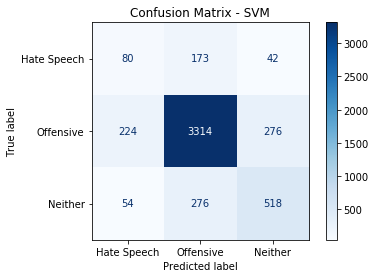

In [31]:
# Plotting Confusion Matrix:
plot_confusion_matrix(svm_model,X_test, y_test, cmap=plt.cm.Blues, display_labels = class_labels)
plt.title('Confusion Matrix - SVM')
plt.show()

### L1 Logistic Regression

In [32]:
# Defining L1 Logistic Regression Model:
l1_model = LogisticRegression(penalty='l1', solver='liblinear')
l1_model.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [33]:
# Performing Classification on the test data:
l1_y_pred = l1_model.predict(X_test)
l1_y_proba = l1_model.predict_proba(X_test)
l1_report = classification_report(y_test, l1_y_pred)
print(l1_report)

              precision    recall  f1-score   support

           0       0.32      0.22      0.26       295
           1       0.88      0.91      0.90      3814
           2       0.68      0.64      0.66       848

    accuracy                           0.82      4957
   macro avg       0.62      0.59      0.61      4957
weighted avg       0.81      0.82      0.82      4957



In [35]:
# Calculating Accuracy:
l1_accuracy = accuracy_score(y_test, l1_y_pred)
print('Accuracy: ',l1_accuracy)

Accuracy:  0.8242888844058907


In [36]:
# Calculating Precion score, Recall score and F1 score:
l1_ps = precision_score(y_test, l1_y_pred, average = 'weighted')
l1_rs = recall_score(y_test, l1_y_pred, average = 'weighted')
l1_f1 = f1_score(y_test, l1_y_pred, average = 'weighted')
print('Precision: ',l1_ps)
print('Recall: ',l1_rs)
print('F1-Score: ',l1_f1)

Precision:  0.8125136727232647
Recall:  0.8242888844058907
F1-Score:  0.8176327496565615


In [34]:
# Calculating Confusion Matrix:
l1_cm = confusion_matrix(y_test, l1_y_pred)
print('Confusion Matrix: \n',l1_cm)

Confusion Matrix: 
 [[  66  189   40]
 [ 118 3478  218]
 [  25  281  542]]


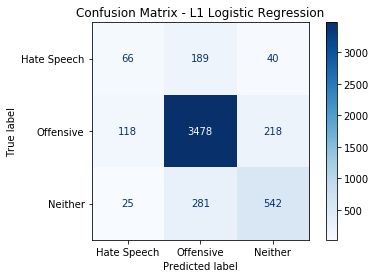

In [37]:
# Plotting Confusion Matrix:
plot_confusion_matrix(l1_model,X_test, y_test, cmap=plt.cm.Blues, display_labels = class_labels)
plt.title('Confusion Matrix - L1 Logistic Regression')
plt.show()

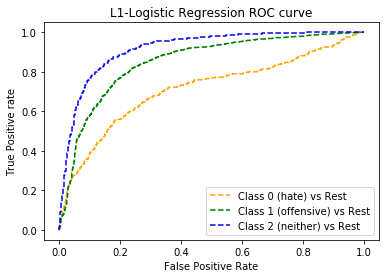

In [38]:
# Calculating and Plotting ROC Curves:
l1_fpr = {}
l1_tpr = {}
l1_thresh ={}

for i in range(n_class):    
    l1_fpr[i], l1_tpr[i], l1_thresh[i] = roc_curve(y_test, l1_y_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(l1_fpr[0], l1_tpr[0], linestyle='--',color='orange', label='Class 0 (hate) vs Rest')
plt.plot(l1_fpr[1], l1_tpr[1], linestyle='--',color='green', label='Class 1 (offensive) vs Rest')
plt.plot(l1_fpr[2], l1_tpr[2], linestyle='--',color='blue', label='Class 2 (neither) vs Rest')
plt.title('L1-Logistic Regression ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

### Naive Bayes Classifier

In [39]:
# Defining Naive Bayes Model:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [40]:
# Performing Classification on the test data:
nb_y_pred = nb_model.predict(X_test)
nb_y_proba = nb_model.predict_proba(X_test)
nb_report = classification_report(y_test, nb_y_pred)
print(nb_report)

              precision    recall  f1-score   support

           0       0.22      0.44      0.29       295
           1       0.92      0.78      0.84      3814
           2       0.56      0.75      0.64       848

    accuracy                           0.75      4957
   macro avg       0.56      0.66      0.59      4957
weighted avg       0.82      0.75      0.77      4957



In [42]:
# Calculating Accuracy:
nb_accuracy = accuracy_score(y_test, nb_y_pred)
print('Accuracy: ',nb_accuracy)

Accuracy:  0.7510591083316522


In [43]:
# Calculating Precion score, Recall score and F1 score:
nb_ps = precision_score(y_test, nb_y_pred, average = 'weighted')
nb_rs = recall_score(y_test, nb_y_pred, average = 'weighted')
nb_f1 = f1_score(y_test, nb_y_pred, average = 'weighted')
print('Precision: ',nb_ps)
print('Recall: ',nb_rs)
print('F1-Score: ',nb_f1)

Precision:  0.8153918632769017
Recall:  0.7510591083316522
F1-Score:  0.7738177974672066


In [41]:
# Calculating Confusion Matrix:
nb_cm = confusion_matrix(y_test, nb_y_pred)
print('Confusion Matrix: \n',nb_cm)

Confusion Matrix: 
 [[ 131  104   60]
 [ 410 2957  447]
 [  57  156  635]]


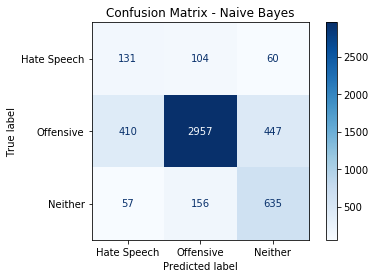

In [44]:
# Plotting Confusion Matrix:
plot_confusion_matrix(nb_model,X_test, y_test, cmap=plt.cm.Blues, display_labels = class_labels)
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

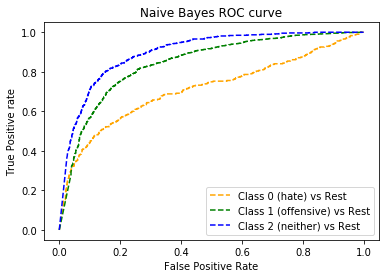

In [45]:
# Calculating and Plotting ROC Curves:
nb_fpr = {}
nb_tpr = {}
nb_thresh ={}

for i in range(n_class):    
    nb_fpr[i], nb_tpr[i], nb_thresh[i] = roc_curve(y_test, nb_y_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(nb_fpr[0], nb_tpr[0], linestyle='--',color='orange', label='Class 0 (hate) vs Rest')
plt.plot(nb_fpr[1], nb_tpr[1], linestyle='--',color='green', label='Class 1 (offensive) vs Rest')
plt.plot(nb_fpr[2], nb_tpr[2], linestyle='--',color='blue', label='Class 2 (neither) vs Rest')
plt.title('Naive Bayes ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

### Random Forest

In [46]:
# Defining Random Forest Model:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [47]:
# Performing Classification on the test data:
rf_y_pred = rf_model.predict(X_test)
rf_y_proba = rf_model.predict_proba(X_test)
rf_report = classification_report(y_test, rf_y_pred)
print(rf_report)

              precision    recall  f1-score   support

           0       0.59      0.03      0.06       295
           1       0.81      0.99      0.89      3814
           2       0.86      0.29      0.44       848

    accuracy                           0.81      4957
   macro avg       0.75      0.44      0.46      4957
weighted avg       0.81      0.81      0.76      4957



In [49]:
# Calculating Accuracy:
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print('Accuracy: ',rf_accuracy)

Accuracy:  0.8131934637885818


In [50]:
# Calculating Precion score, Recall score and F1 score:
rf_ps = precision_score(y_test, rf_y_pred, average = 'weighted')
rf_rs = recall_score(y_test, rf_y_pred, average = 'weighted')
rf_f1 = f1_score(y_test, rf_y_pred, average = 'weighted')
print('Precision: ',rf_ps)
print('Recall: ',rf_rs)
print('F1-Score: ',rf_f1)

Precision:  0.8059775940499329
Recall:  0.8131934637885818
F1-Score:  0.7643277092145109


In [48]:
# Calculating Confusion Matrix:
rf_cm = confusion_matrix(y_test, rf_y_pred)
print('Confusion Matrix: \n',rf_cm)

Confusion Matrix: 
 [[  10  278    7]
 [   7 3773   34]
 [   0  600  248]]


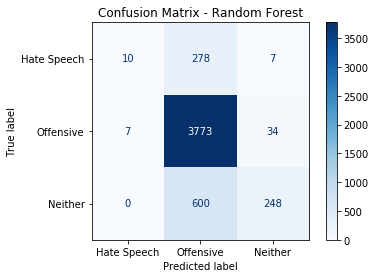

In [51]:
# Plotting Confusion Matrix:
plot_confusion_matrix(rf_model,X_test, y_test, cmap=plt.cm.Blues, display_labels = class_labels)
plt.title('Confusion Matrix - Random Forest')
plt.show()

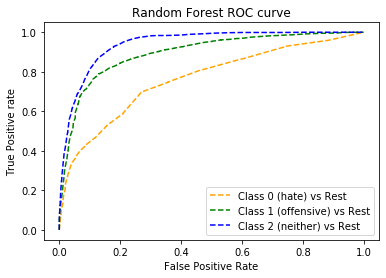

In [52]:
# Calculating and Plotting ROC Curves:
rf_fpr = {}
rf_tpr = {}
rf_thresh ={}

for i in range(n_class):    
    rf_fpr[i], rf_tpr[i], rf_thresh[i] = roc_curve(y_test, rf_y_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(rf_fpr[0], rf_tpr[0], linestyle='--',color='orange', label='Class 0 (hate) vs Rest')
plt.plot(rf_fpr[1], rf_tpr[1], linestyle='--',color='green', label='Class 1 (offensive) vs Rest')
plt.plot(rf_fpr[2], rf_tpr[2], linestyle='--',color='blue', label='Class 2 (neither) vs Rest')
plt.title('Random Forest ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')